In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from nltk.probability import FreqDist

In [147]:
posts_list = pd.read_pickle('./data/investing-posts.pkl')
df = pd.DataFrame(posts_list)
post_manip = df[['title','selftext','created_utc']]    
post_manip['text'] = post_manip['title'] + ' ' + post_manip['selftext']

In [154]:
post_manip['word_count'] = post_manip['text'].apply(lambda x: len(str(x).split(" ")))
post_manip = post_manip[post_manip.word_count < 200]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [174]:
stop_words = set(stopwords.words('english'))
new_stop_words = set(['removed','x200b', 'amp'])
stop_words = stop_words.union(new_stop_words)
corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for x in post_manip['text']:
    text = str(x.lower())
    text = tokenizer.tokenize(re.sub(r'https?://\S+', '', text))
    ps=PorterStemmer()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [175]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

[Text(0, 0, 'stock'),
 Text(0, 0, 'market'),
 Text(0, 0, 'company'),
 Text(0, 0, 'trading'),
 Text(0, 0, 'would'),
 Text(0, 0, 'year'),
 Text(0, 0, 'like'),
 Text(0, 0, 'share'),
 Text(0, 0, 'new'),
 Text(0, 0, 'buy'),
 Text(0, 0, 'time'),
 Text(0, 0, 'price'),
 Text(0, 0, 'get'),
 Text(0, 0, 'know'),
 Text(0, 0, 'trade'),
 Text(0, 0, '2019'),
 Text(0, 0, 'good'),
 Text(0, 0, 'day'),
 Text(0, 0, 'investing'),
 Text(0, 0, 'money')]

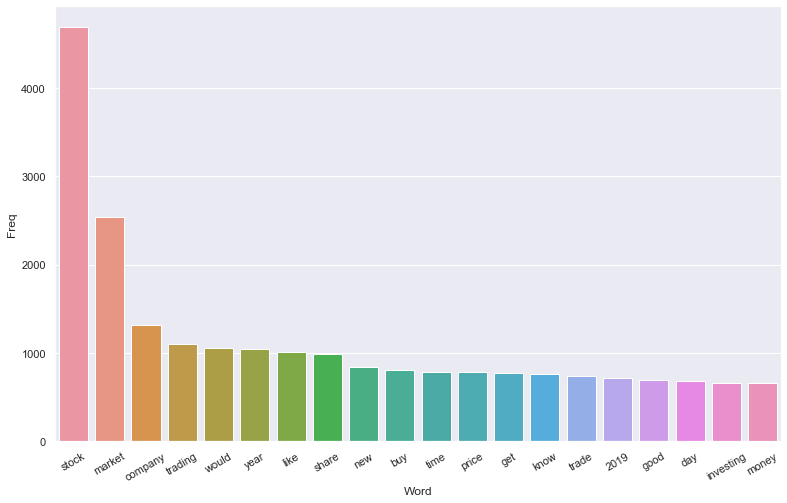

In [176]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

             Bi-gram  Freq
0       stock market   947
1          amp x200b   814
2          long term   266
3            amp 500   150
4         would like   144
5        stock price   117
6         free stock   112
7        anyone know   101
8          trade war    96
9         short term    96
10         last year    94
11       wall street    92
12   halftime report    92
13         new stock    85
14        index fund    84
15          year old    83
16  earnings release    82
17        make money    82
18     stock removed    81
19         look like    81


[Text(0, 0, 'stock market'),
 Text(0, 0, 'amp x200b'),
 Text(0, 0, 'long term'),
 Text(0, 0, 'amp 500'),
 Text(0, 0, 'would like'),
 Text(0, 0, 'stock price'),
 Text(0, 0, 'free stock'),
 Text(0, 0, 'anyone know'),
 Text(0, 0, 'trade war'),
 Text(0, 0, 'short term'),
 Text(0, 0, 'last year'),
 Text(0, 0, 'wall street'),
 Text(0, 0, 'halftime report'),
 Text(0, 0, 'new stock'),
 Text(0, 0, 'index fund'),
 Text(0, 0, 'year old'),
 Text(0, 0, 'earnings release'),
 Text(0, 0, 'make money'),
 Text(0, 0, 'stock removed'),
 Text(0, 0, 'look like')]

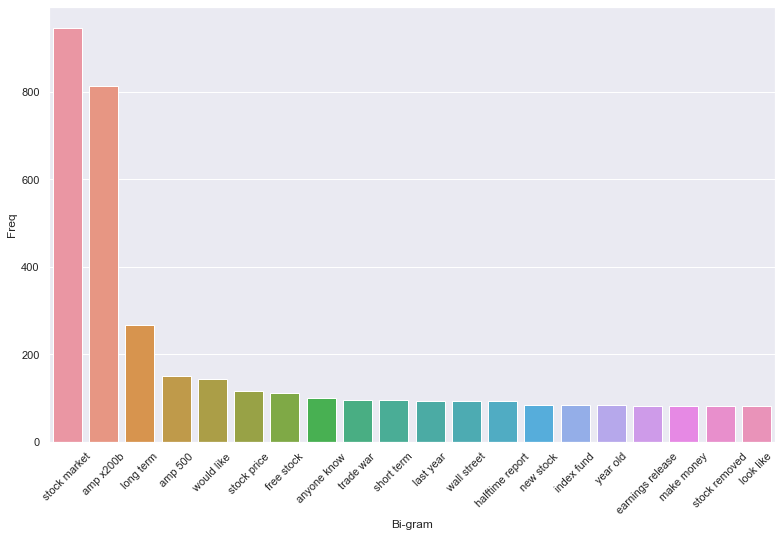

In [171]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                        Tri-gram  Freq
0                   amp x200b gt    64
1   anticipated earnings release    63
2               stock sign bonus    61
3                free stock sign    61
4                   10 1000 free    60
5                1000 free stock    60
6               sign bonus nvstr    60
7        tackle trading halftime    59
8        trading halftime report    59
9          stock picking contest    53
10        release week beginning    50
11         earnings release week    49
12           2019 contest update    46
13                 amp x200b amp    45
14               x200b amp x200b    44
15            2019 stock picking    40
16          long term investment    38
17              new stock market    36
18           update market close    35
19         contest update market    34


[Text(0, 0, 'amp x200b gt'),
 Text(0, 0, 'anticipated earnings release'),
 Text(0, 0, 'stock sign bonus'),
 Text(0, 0, 'free stock sign'),
 Text(0, 0, '10 1000 free'),
 Text(0, 0, '1000 free stock'),
 Text(0, 0, 'sign bonus nvstr'),
 Text(0, 0, 'tackle trading halftime'),
 Text(0, 0, 'trading halftime report'),
 Text(0, 0, 'stock picking contest'),
 Text(0, 0, 'release week beginning'),
 Text(0, 0, 'earnings release week'),
 Text(0, 0, '2019 contest update'),
 Text(0, 0, 'amp x200b amp'),
 Text(0, 0, 'x200b amp x200b'),
 Text(0, 0, '2019 stock picking'),
 Text(0, 0, 'long term investment'),
 Text(0, 0, 'new stock market'),
 Text(0, 0, 'update market close'),
 Text(0, 0, 'contest update market')]

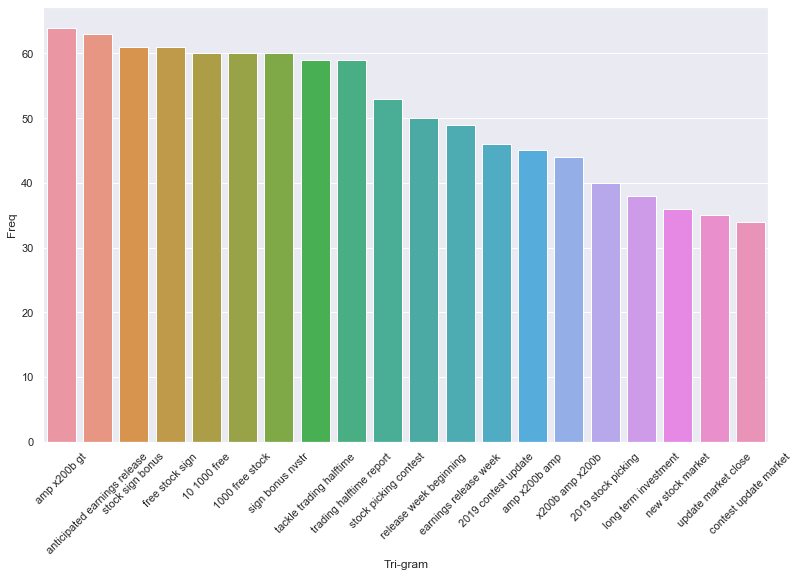

In [173]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [132]:
s = ""

for x in df['selftext']:
    s += str(x) + '. '

In [12]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
filtered = tokenizer.tokenize(s)
new_filtered = []
for x in filtered:
    if str(x).lower() not in stop_words:
        new_filtered += [x]

[('amp', 21515), ('https', 21116), ('gt', 11369), ('com', 11146), ('io', 9979), ('fintel', 9827), ('2019', 7207), ('us', 7174), ('CLICK', 6729), ('earnings', 6229), ('www', 6198), ('1', 5988), ('Inc', 5475), ('stock', 4792), ('2', 4550), ('market', 3887), ('http', 3644), ('n', 3597), ('3', 3522), ('company', 3491), ('Link', 3209), ('13D', 3200), ('year', 3173), ('Filings', 3169), ('png', 3153), ('sec', 3095), ('gov', 3093), ('edgar', 3080), ('cgi', 3077), ('bin', 3076), ('browse', 3075), ('CIK', 3075), ('8209', 3073), ('dateb', 3073), ('datea', 3073), ('5', 3052), ('07', 3051), ('4', 3015), ('imgur', 2874), ('0', 2804), ('CHART', 2712), ('stocks', 2683), ('STOCK', 2639), ('10', 2592), ('share', 2482), ('release', 2378), ('7', 2310), ('6', 2290), ('000', 2280), ('last', 2262), ('finviz', 2227), ('ashx', 2209), ('chart', 2115), ('data', 2050), ('P', 2046), ('week', 2004), ('elite', 1964), ('since', 1944), ('8', 1897), ('p', 1861), ('per', 1832), ('cnbc', 1799), ('removed', 1785), ('c', 1

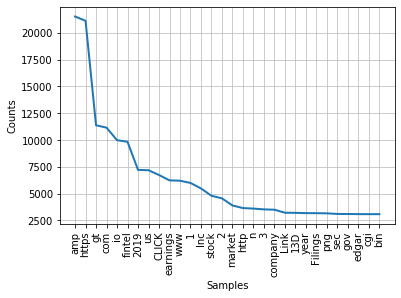

In [14]:
fdist = FreqDist(new_filtered)
print(fdist.most_common(100))
fdist.plot(30,cumulative=False)
plt.show()